In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio

In [2]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')

In [3]:
from scripts.core import TN_utils, models, compiling, optimizers


Using gpu device 1: Tesla M2070 (CNMeM is disabled, CuDNN not available)


In [4]:
fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(0, mask_thresh=0.5)

(430080, 30, 1) (430080, 1) (430080,)


In [5]:
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(fe_vec, gt_vec, mask_vec, split_data=False)

In [7]:
data_set[0].shape, data_set[1].shape

((26857, 1, 30), (26857, 1))

In [8]:
rcn_2layer = models.Rcn2layer_wo_bn(
    n_tensors_list=[fe_vec.shape[1], 100],
    func_key_list=["relu", "relu"],
    l2_reg=0.,
    gamma_scale=10**-2,
    drop_list=[1., 1.],
    bias_scale=0.)
                            
result = compiling.compile_bn(
    data_set=data_set,
    model=rcn_2layer,
    make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, s_input, s_target, s_test_input, s_test_target, param_list= result

batch_size = 10500
N = s_input.get_value(borrow=True).shape[0]
batch_size = batch_size
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = data_set[2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

try:
    for i_epoch in xrange(n_epochs):
        index_list = np.random.permutation(index_list)
        test_index_list = np.random.permutation(test_index_list)
        
        for i_batch in xrange(n_batchs):
            t = t + 1.
            f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
            
        if i_epoch % interval == 0:
            training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
            training_error_array[i_epoch // interval + 1] = training_error
            test_error = f_test_error(0, test_index_list, 1000)[0]
            test_error_array[i_epoch // interval + 1] = test_error
        
            alpha **= 0.99
	    print training_error, test_error
finally:
    pass

pred_train = np.squeeze(f_output(data_set[0])[0])
pred_test = np.squeeze(f_output(data_set[2])[0])

/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 8 is not part of the computational graph needed to compute the outputs: beta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 9 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:74: UserWar

0.911352396011 0.910283029079
0.158390000463 0.155398905277
0.0771680623293 0.0780626088381
0.0509625300765 0.0505142845213
0.0357180573046 0.0389112457633
0.0235569253564 0.0238929074258
0.0137841384858 0.0128391254693
0.00936776120216 0.0090178065002
0.00791872851551 0.00719278259203
0.00761048821732 0.00738731212914
0.00726034771651 0.00772167881951
0.00716018816456 0.00757421646267
0.00654502771795 0.00649778777733
0.0060718213208 0.00694002630189
0.00590568268672 0.0055175172165
0.00556034501642 0.00578789319843
0.00505759380758 0.00517356069759
0.0044864313677 0.00442478293553
0.00425086030737 0.00414841016755
0.0036246329546 0.00410717027262
0.0033513547387 0.00357217760757


/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:74: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 4 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


In [21]:
pred_train = f_output(data_set[0])[0][:, 0]

In [22]:
pred_train.shape

(26857, 1)

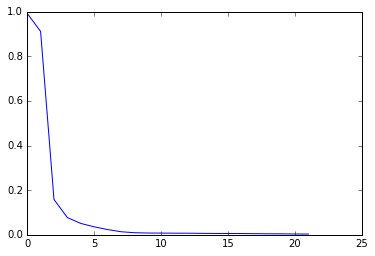

In [23]:
plt.plot(training_error_array)

In [24]:
pred_train.shape

(26857, 1)

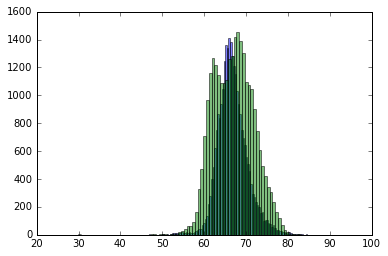

In [25]:

stats = plt.hist(np.linalg.norm(gt_norm_coef*pred_train, axis=1), bins=100, alpha=0.5)
stats = plt.hist(np.linalg.norm(gt_vec[mask_vec], axis=1), bins=100, alpha=0.5)

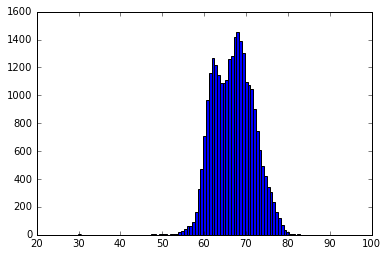

In [26]:
stats = plt.hist(np.linalg.norm(gt_vec[mask_vec], axis=1), bins=100)

(1, 112, 128, 30)


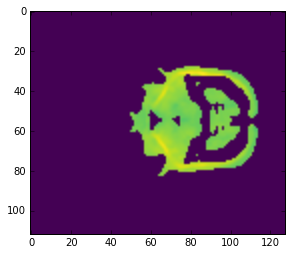

In [29]:
reload(TN_utils)
padded = TN_utils.pad_transpose_pred(pred_train, mask_vec, gt_norm_coef, vol_shape)
plt.imshow(np.linalg.norm(padded, axis=0)[:, :, 15])

In [30]:
sio.savemat('../../../results/hardi_in_ex/May25/a0.mat', {'pred' : padded})